<a href="https://colab.research.google.com/github/puneet-08/projects/blob/main/Neural_Style_Transfer_Book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

In this notebook we are going to implement Neural Style Transfer - an approach whereby we generate a new image by merging distinct features from two images.

Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

In [1]:
#Importing useful directories

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg19 import VGG19

Downloading and visualizing **content image** and **stlye reference image**

In [2]:
content_image_path = keras.utils.get_file("sf.jpg", 
                                       origin="https://img-datasets.s3.amazonaws.com/sf.jpg")

style_reference_image_path = keras.utils.get_file("starry_night.jpg",
                                                  origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

958464/943128 [==============================] - 0s 0us/step


Content Image

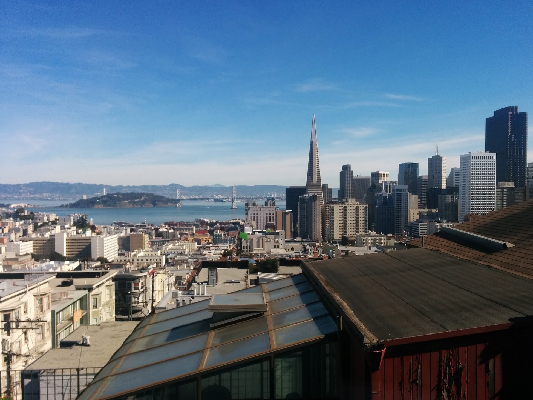

In [3]:
#Loading and resizing image
original_width, original_height = keras.utils.load_img(content_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

content_image = keras.utils.load_img(content_image_path, target_size=(img_height, img_width))
content_image_array = tf.keras.utils.img_to_array(content_image)
content_image

Style Image

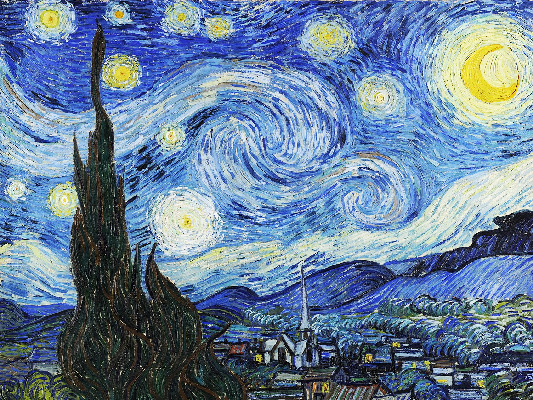

In [4]:
#Loading and resizing image

style_image = keras.utils.load_img(style_reference_image_path, target_size=(img_height, img_width))
style_image_array = tf.keras.utils.img_to_array(style_image)
style_image

## Model

We are going to use pretrained VGG-19 model trained on 'Imagenet' dataset. 

The model is used to extract features from both the style and content images, which are futher used to generate the blended image.

In [5]:
vgg = VGG19(weights = 'imagenet',include_top= False)
vgg.summary()

outputs_dict = dict([(layer.name, layer.output) for layer in vgg.layers])
feature_extractor = keras.Model(inputs=vgg.inputs, outputs=outputs_dict)

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

Since we are using VGG-19 network, inputs are preprocessed before they are input to the model. Also the output from the vgg model is deprocessed adequately to undo the preprocessing transformations.

In [6]:
#functions to pre-process and de-process the images

def preprocess_image(img):
  if len(img.shape) == 4:
    img = keras.applications.vgg19.preprocess_input(img)
    return img
  else:
    img = tf.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939 #Zero-centering by removing the mean pixel value from ImageNet. This reverses a transformation done by vgg19.preprocess_input.
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1] #Converts images from 'BGR' to 'RGB'. This is also part of the reversal of vgg19.preprocess_input.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

### Content loss

The content loss function ensures that the activations of the higher layers are similar between the content image and the generated image.

It is calculated by Euclidean distance between the respective intermediate higher-level feature representation of the generated image and the content image.

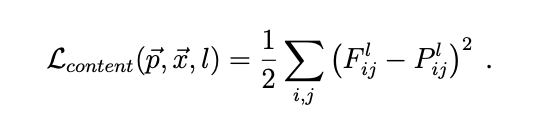

In [7]:
def content_loss(content_img, gen_img):
  return tf.math.reduce_sum(tf.math.square(content_img - gen_img))

In [8]:
content_loss(content_image_array, style_image_array)

<tf.Tensor: shape=(), dtype=float32, numpy=4813056000.0>

### Style Loss

Style information is measured as the amount of correlation present between features maps in a given layer. The style loss function makes sure that the correlation of activations in all the layers are similar between the style image and the generated image. 

Style matrix, the matrix which stores correlation between different feature maps or channels, can be computed by calculating the Gram Matrix -

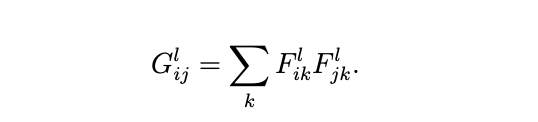

In [9]:
def gram_matrix(input_tensor):
  if len(input_tensor.shape) ==3:
    input_tensor = tf.expand_dims(input_tensor, axis = 0)
  result = tf.linalg.einsum('bijc,bijd -> bcd', input_tensor, input_tensor)
  return result

In [10]:
gram_matrix(content_image_array)

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[2.5091773e+09, 2.8369818e+09, 3.1122248e+09],
        [2.8369818e+09, 3.4596982e+09, 4.0018017e+09],
        [3.1122248e+09, 4.0018017e+09, 4.8080415e+09]]], dtype=float32)>

Style loss is calculated by the calculating Euclidean distance between the gram matrices of the generated image and the style reference image.

The contribution of each layer in the style information and total style loss are calculated by the below formulas:

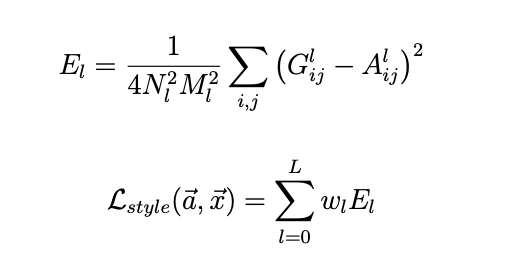

In [11]:
def style_loss(style_img, gen_img):
  S = gram_matrix(style_img)
  G = gram_matrix(gen_img)
  channels = 3
  size = img_width * img_height
  loss = tf.math.reduce_sum(tf.math.square(S-G))/(4*(channels**2)*(size**2))
  return loss

In [12]:
style_loss(style_image_array, content_image_array)

<tf.Tensor: shape=(), dtype=float32, numpy=6072386.5>

Style loss is calculated at multple layers - "block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"

Content loss is calculated at - "block5_conv2"

And finally we take weighted sum of content and stlye loss to calculate the total loss.

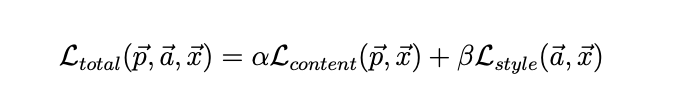

In [13]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1"
    ]

content_layer_name = "block5_conv2"

style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(gen_image, style_image, content_image):
  
  concat_image = tf.concat([gen_image, style_image, content_image], axis =0)
  concat_features = feature_extractor(concat_image)

  content_loss_agg = content_loss(concat_features[content_layer_name][2] , concat_features[content_layer_name][0])
  style_loss_agg = np.sum([style_loss(concat_features[layer][1], concat_features[layer][0]) for layer in style_layer_names])

  return ((content_weight*content_loss_agg) + ((style_weight /len(style_layer_names))* style_loss_agg))

In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    ))

In [ ]:
@tf.function
def compute_loss_and_grads(gen_image, style_image, content_image):
  with tf.GradientTape() as tape:
    loss = compute_loss(gen_image, style_image, content_image)
  grads = tape.gradient(loss, gen_image)
  return loss, grads

### Training and generating images

In [ ]:
epochs = 4000
from tqdm import tqdm

gen_image_array = tf.Variable(preprocess_image(content_image_array))
style_image_array = preprocess_image(style_image_array)
content_image_array = preprocess_image(content_image_array)

for i in tqdm(range(1, epochs+1)):
  loss, grads = compute_loss_and_grads(gen_image_array, style_image_array, content_image_array)

  optimizer.apply_gradients([(grads, gen_image_array)])
  if i % 100 == 0:
    print(f"Iteration {i}: loss={loss:.2f}")
    img = deprocess_image(gen_image_array.numpy())
    fname = f"combination_image_at_iteration_{i}.png"
    keras.utils.save_img(fname, img)

  2%|▎         | 100/4000 [01:15<1:42:44,  1.58s/it]

Iteration 100: loss=1690.88


  5%|▌         | 200/4000 [02:29<1:39:34,  1.57s/it]

Iteration 200: loss=813.24


  8%|▊         | 300/4000 [03:43<1:37:10,  1.58s/it]

Iteration 300: loss=570.84


 10%|█         | 400/4000 [04:58<1:34:39,  1.58s/it]

Iteration 400: loss=463.42


 12%|█▎        | 500/4000 [06:12<1:31:41,  1.57s/it]

Iteration 500: loss=400.50


 15%|█▌        | 600/4000 [07:26<1:29:14,  1.57s/it]

Iteration 600: loss=358.03


 18%|█▊        | 700/4000 [08:40<1:26:43,  1.58s/it]

Iteration 700: loss=327.01


 20%|██        | 800/4000 [09:55<1:23:53,  1.57s/it]

Iteration 800: loss=303.19


 22%|██▎       | 900/4000 [11:09<1:21:31,  1.58s/it]

Iteration 900: loss=284.30


 25%|██▌       | 1000/4000 [12:23<1:18:46,  1.58s/it]

Iteration 1000: loss=268.90


 28%|██▊       | 1100/4000 [13:38<1:16:00,  1.57s/it]

Iteration 1100: loss=256.10


 30%|███       | 1200/4000 [14:52<1:13:19,  1.57s/it]

Iteration 1200: loss=245.29


 32%|███▎      | 1300/4000 [16:06<1:11:07,  1.58s/it]

Iteration 1300: loss=236.04


 35%|███▌      | 1400/4000 [17:20<1:08:33,  1.58s/it]

Iteration 1400: loss=228.03


 38%|███▊      | 1500/4000 [18:35<1:05:43,  1.58s/it]

Iteration 1500: loss=221.02


 40%|████      | 1600/4000 [19:49<1:03:07,  1.58s/it]

Iteration 1600: loss=214.84


 42%|████▎     | 1700/4000 [21:03<1:00:20,  1.57s/it]

Iteration 1700: loss=209.33


 45%|████▌     | 1800/4000 [22:18<57:51,  1.58s/it]

Iteration 1800: loss=204.40


 48%|████▊     | 1900/4000 [23:32<55:18,  1.58s/it]

Iteration 1900: loss=199.96


 50%|█████     | 2000/4000 [24:46<52:31,  1.58s/it]

Iteration 2000: loss=195.95


 52%|█████▎    | 2100/4000 [26:01<49:54,  1.58s/it]

Iteration 2100: loss=192.30


 55%|█████▌    | 2200/4000 [27:15<47:06,  1.57s/it]

Iteration 2200: loss=188.97


 57%|█████▊    | 2300/4000 [28:29<44:41,  1.58s/it]

Iteration 2300: loss=185.93


 60%|██████    | 2400/4000 [29:44<41:58,  1.57s/it]

Iteration 2400: loss=183.13


 62%|██████▎   | 2500/4000 [30:58<39:26,  1.58s/it]

Iteration 2500: loss=180.56


 65%|██████▌   | 2600/4000 [32:12<36:39,  1.57s/it]

Iteration 2600: loss=178.18


 68%|██████▊   | 2700/4000 [33:26<34:14,  1.58s/it]

Iteration 2700: loss=175.97


 70%|███████   | 2800/4000 [34:41<31:28,  1.57s/it]

Iteration 2800: loss=173.93


 72%|███████▎  | 2900/4000 [35:55<28:53,  1.58s/it]

Iteration 2900: loss=172.03


 75%|███████▌  | 3000/4000 [37:09<26:13,  1.57s/it]

Iteration 3000: loss=170.27


 78%|███████▊  | 3100/4000 [38:23<23:38,  1.58s/it]

Iteration 3100: loss=168.63


 80%|████████  | 3200/4000 [39:38<20:58,  1.57s/it]

Iteration 3200: loss=167.09


 82%|████████▎ | 3300/4000 [40:52<18:23,  1.58s/it]

Iteration 3300: loss=165.65


 85%|████████▌ | 3400/4000 [42:06<15:44,  1.57s/it]

Iteration 3400: loss=164.30


 88%|████████▊ | 3500/4000 [43:20<13:06,  1.57s/it]

Iteration 3500: loss=163.04


 90%|█████████ | 3600/4000 [44:35<10:29,  1.57s/it]

Iteration 3600: loss=161.85


 92%|█████████▎| 3700/4000 [45:49<07:53,  1.58s/it]

Iteration 3700: loss=160.72


 95%|█████████▌| 3800/4000 [47:03<05:15,  1.58s/it]

Iteration 3800: loss=159.67


 98%|█████████▊| 3900/4000 [48:18<02:37,  1.58s/it]

Iteration 3900: loss=158.68


100%|██████████| 4000/4000 [49:32<00:00,  1.35it/s]

Iteration 4000: loss=157.74


Generated Image after 100 epochs:

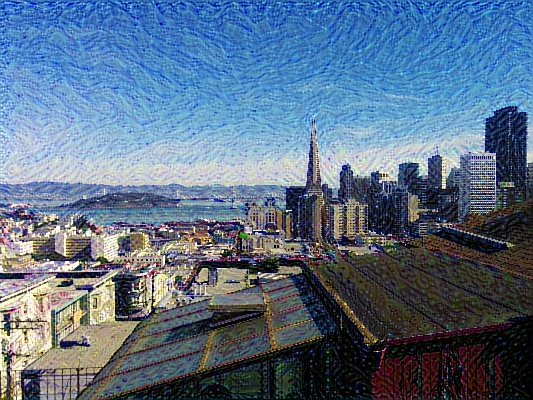

Generated image after 4000 epochs:

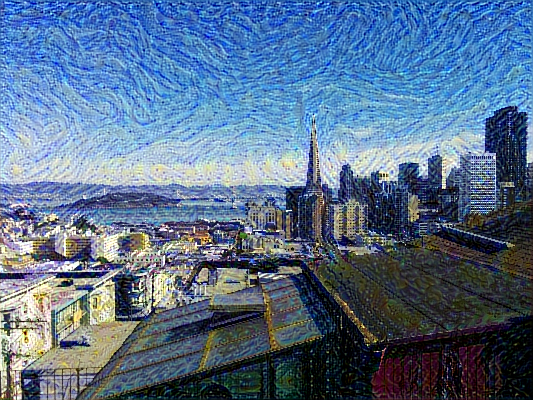